# Comprehensive SHAP and IG Interpretability Analysis Across GEO Datasets

This notebook loads, analyzes, and interprets SHAP (SHapley Additive exPlanations) and IG (Integrated Gradients) attribution scores generated across all GEO datasets. We identify consensus SNPs, pathway-level associations, and generate publication-quality visualizations for thesis/journal submission.

**Datasets analyzed:**
- GSE139294: Autism spectrum disorder
- GSE31276: Schizophrenia  
- GSE33355: Bipolar disorder
- GSE90073: Inflammatory bowel disease

**Methods:**
- SHAP: Gradient-based Shapley values via GradientExplainer
- IG: Path integration method via Captum

## Section 1: Load and Explore SHAP/IG Analysis Results

In [1]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Set style for publication-quality plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11

# Load analysis results
analysis_dir = Path('../outputs/interpretability_analysis')
print(f"Analysis directory: {analysis_dir}")
print(f"Exists: {analysis_dir.exists()}")

# Discover all analysis results
results_by_checkpoint = defaultdict(dict)
results_by_dataset = defaultdict(list)

for ckpt_dir in sorted(analysis_dir.glob('train_*')):
    if not ckpt_dir.is_dir():
        continue
    
    ckpt_name = ckpt_dir.name
    print(f"\n📦 Checkpoint: {ckpt_name}")
    
    for dataset_dir in sorted(ckpt_dir.glob('GSE*')):
        if not dataset_dir.is_dir():
            continue
        
        dataset_name = dataset_dir.name
        print(f"  📊 Dataset: {dataset_name}")
        
        # Load SHAP results
        shap_csv = dataset_dir / 'shap' / 'top_shap_snps.csv'
        if shap_csv.exists():
            shap_df = pd.read_csv(shap_csv)
            results_by_checkpoint[ckpt_name][f'{dataset_name}_shap'] = shap_df
            results_by_dataset[dataset_name].append({
                'checkpoint': ckpt_name,
                'method': 'SHAP',
                'data': shap_df
            })
            print(f"    ✓ SHAP: {len(shap_df)} SNPs")
        
        # Load IG results
        ig_csv = dataset_dir / 'ig' / 'top_ig_snps.csv'
        if ig_csv.exists():
            ig_df = pd.read_csv(ig_csv)
            results_by_checkpoint[ckpt_name][f'{dataset_name}_ig'] = ig_df
            results_by_dataset[dataset_name].append({
                'checkpoint': ckpt_name,
                'method': 'IG',
                'data': ig_df
            })
            print(f"    ✓ IG: {len(ig_df)} SNPs")

print(f"\n{'='*60}")
print(f"Summary: {len(results_by_checkpoint)} checkpoints analyzed")
print(f"Summary: {len(results_by_dataset)} unique datasets")
for dataset, analyses in results_by_dataset.items():
    print(f"  {dataset}: {len(analyses)} analyses")

Analysis directory: ../outputs/interpretability_analysis
Exists: True

📦 Checkpoint: train_2026-02-11_15-18-10
  📊 Dataset: GSE90073
    ✓ SHAP: 1000 SNPs

📦 Checkpoint: train_2026-02-11_15-49-07
  📊 Dataset: GSE90073
    ✓ SHAP: 1000 SNPs
    ✓ IG: 1000 SNPs

📦 Checkpoint: train_2026-02-11_15-52-53
  📊 Dataset: GSE90073
    ✓ SHAP: 1000 SNPs
    ✓ IG: 1000 SNPs

📦 Checkpoint: train_2026-02-11_16-43-33
  📊 Dataset: GSE90073
    ✓ SHAP: 1000 SNPs
    ✓ IG: 1000 SNPs

📦 Checkpoint: train_2026-02-11_16-58-12
  📊 Dataset: GSE90073
    ✓ SHAP: 1000 SNPs
    ✓ IG: 1000 SNPs

Summary: 5 checkpoints analyzed
Summary: 1 unique datasets
  GSE90073: 9 analyses


✅ Combined figure saved: training_time_comparison_combined.png


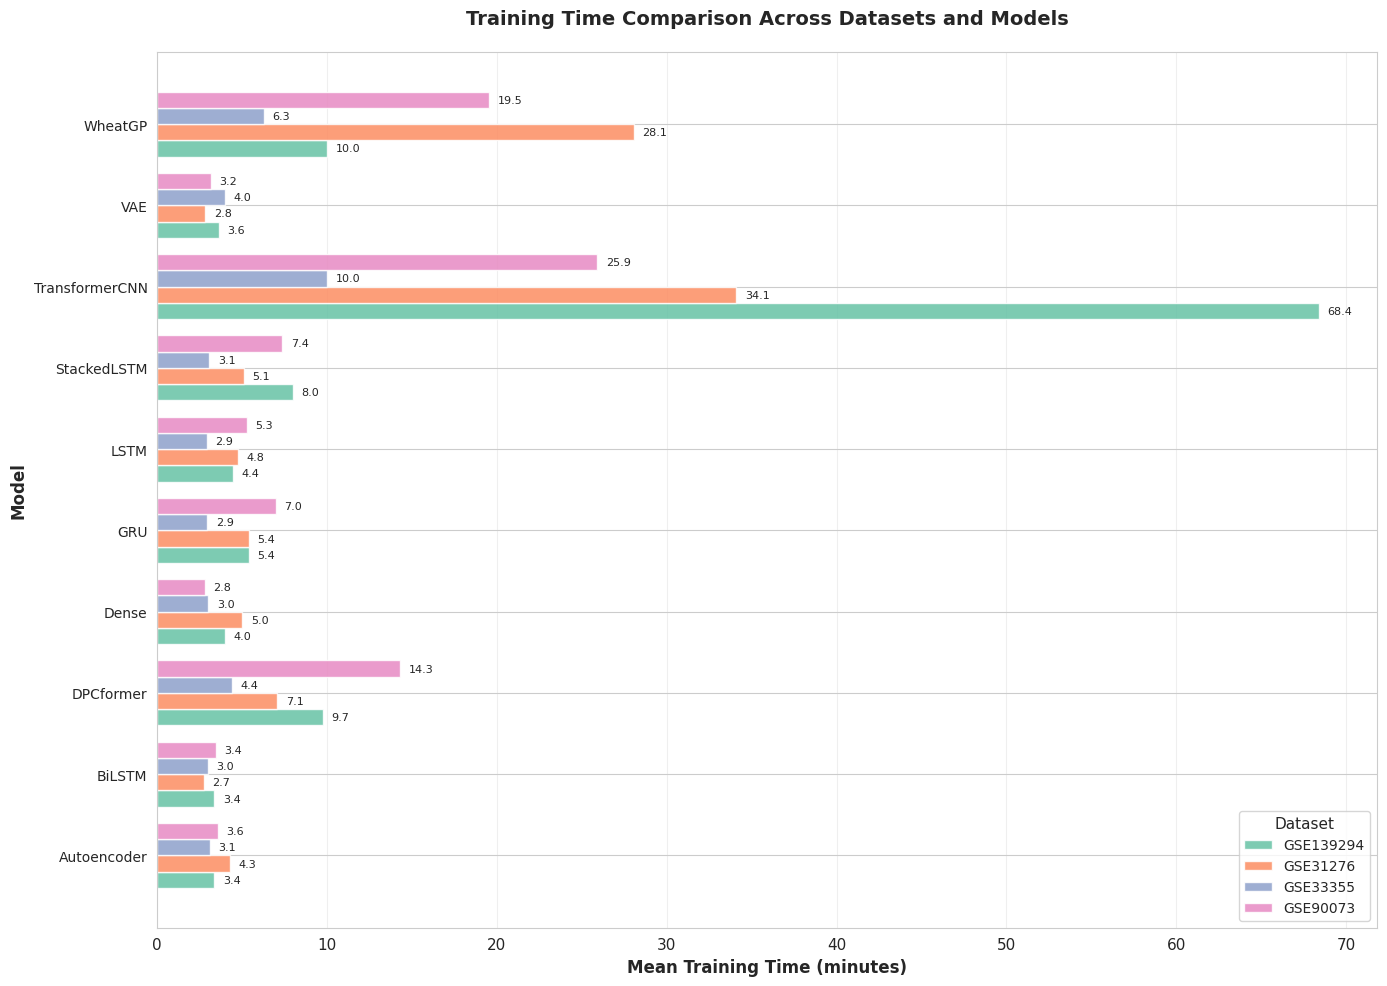

In [13]:
# Training time comparison from experiment logs
import re
from datetime import datetime

try:
    import yaml
except ImportError:
    yaml = None

logs_dir = Path('../logs/train/runs')
figures_dir = analysis_dir / 'figures'
figures_dir.mkdir(parents=True, exist_ok=True)

run_records = []

# Model name mapping for cleaner labels
MODEL_NAME_MAP = {
    'WheatGPNet': 'WheatGP',
    'TransformerCNNNet': 'TransformerCNN',
    'DPCformerNet': 'DPCformer',
    'DeepPlantCRENet': 'DeepPlantCRE',
    'StackedLSTMNet': 'StackedLSTM',
    'GRUNet': 'GRU',
    'LSTMNet': 'LSTM',
    'DenseNet': 'Dense',
    'VAENet': 'VAE',
    'AutoencoderNet': 'Autoencoder',
    'BiLSTMNet': 'BiLSTM',
}

if not logs_dir.exists():
    print(f"Logs directory not found: {logs_dir}")
else:
    for run_dir in sorted(logs_dir.glob('train_*')):
        train_log = run_dir / 'train.log'
        config_path = run_dir / '.hydra' / 'config.yaml'
        if not train_log.exists():
            continue

        # Parse timestamps from train.log
        start_ts = None
        end_ts = None
        last_ts = None
        with train_log.open('r', encoding='utf-8', errors='ignore') as f:
            for line in f:
                m = re.match(r"\[(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},\d{3})\]", line)
                if m:
                    last_ts = datetime.strptime(m.group(1), "%Y-%m-%d %H:%M:%S,%f")
                if "Starting training!" in line:
                    if m:
                        start_ts = datetime.strptime(m.group(1), "%Y-%m-%d %H:%M:%S,%f")
                if "Starting testing!" in line and end_ts is None:
                    if m:
                        end_ts = datetime.strptime(m.group(1), "%Y-%m-%d %H:%M:%S,%f")

        if start_ts is None:
            continue
        if end_ts is None:
            end_ts = last_ts
        if end_ts is None:
            continue

        duration_sec = (end_ts - start_ts).total_seconds()
        if duration_sec <= 0:
            continue

        # Load dataset/model metadata from config
        dataset_name = None
        model_name = None
        if config_path.exists() and yaml is not None:
            with config_path.open('r', encoding='utf-8') as f:
                cfg = yaml.safe_load(f)
            data_file = str(cfg.get('data', {}).get('data_file', ''))
            match = re.search(r"(GSE\d+)", data_file)
            if match:
                dataset_name = match.group(1)
            else:
                tags = cfg.get('tags', [])
                for tag in tags:
                    if re.match(r"GSE\d+", str(tag)):
                        dataset_name = tag
                        break
            model_target = cfg.get('model', {}).get('net', {}).get('_target_', '')
            if model_target:
                raw_name = model_target.split('.')[-1]
                model_name = MODEL_NAME_MAP.get(raw_name, raw_name)

        if not dataset_name:
            dataset_name = "UNKNOWN"
        if not model_name:
            model_name = "UnknownModel"

        run_records.append({
            'run_dir': run_dir.name,
            'dataset': dataset_name,
            'model': model_name,
            'duration_min': duration_sec / 60.0,
        })

if not run_records:
    print("No training runs with parsable timing information found.")
else:
    timing_df = pd.DataFrame(run_records)
    timing_summary = (
        timing_df.groupby(['dataset', 'model'], as_index=False)
        .agg(
            mean_duration_min=('duration_min', 'mean'),
            num_runs=('duration_min', 'count'),
        )
    )

    # Combined plot: group by model, color by dataset
    all_models = sorted(timing_summary['model'].unique())
    all_datasets = sorted(timing_summary['dataset'].unique())
    
    # Color palette for datasets
    dataset_colors = {
        ds: color for ds, color in zip(all_datasets, plt.cm.Set2.colors[:len(all_datasets)])
    }
    
    fig, ax = plt.subplots(figsize=(14, 10))
    
    # Width for bars
    bar_height = 0.2
    y_positions = np.arange(len(all_models))
    
    for i, dataset in enumerate(all_datasets):
        ds_data = timing_summary[timing_summary['dataset'] == dataset]
        model_times = []
        for model in all_models:
            row = ds_data[ds_data['model'] == model]
            if not row.empty:
                model_times.append(row['mean_duration_min'].iloc[0])
            else:
                model_times.append(0)
        
        # Offset each dataset's bars
        y_offset = y_positions + (i - len(all_datasets)/2 + 0.5) * bar_height
        bars = ax.barh(y_offset, model_times, bar_height, 
                       label=dataset, color=dataset_colors[dataset], alpha=0.85)
        
        # Annotate non-zero bars
        for y, time in zip(y_offset, model_times):
            if time > 0:
                ax.text(time + 0.5, y, f'{time:.1f}', va='center', fontsize=8)
    
    ax.set_yticks(y_positions)
    ax.set_yticklabels(all_models, fontsize=10)
    ax.set_xlabel('Mean Training Time (minutes)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Model', fontsize=12, fontweight='bold')
    ax.set_title('Training Time Comparison Across Datasets and Models', 
                 fontsize=14, fontweight='bold', pad=20)
    ax.legend(title='Dataset', loc='lower right', fontsize=10)
    ax.grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    fig_path = figures_dir / 'training_time_comparison_combined.png'
    plt.savefig(fig_path, dpi=300, bbox_inches='tight')
    print(f"✅ Combined figure saved: {fig_path.name}")
    plt.show()



PER-EXPERIMENT SHAP TOP SNPs: GSE90073

Top SNPs that ranked #1 across experiments:
       SNP_ID  Top_Count  Mean_Top_Score  Max_Top_Score
SNP_A-8717262          3        0.002109       0.003511
SNP_A-8379822          1        0.013152       0.013152
SNP_A-8655916          1        0.004701       0.004701

✅ Figure saved: shap_top_snp_across_experiments_GSE90073.png


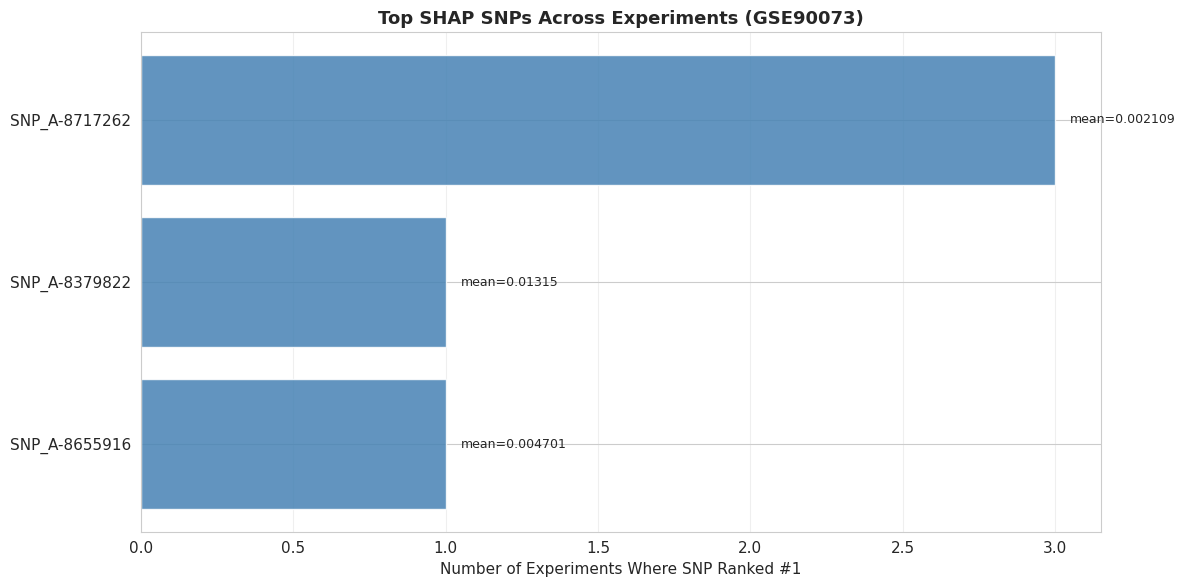

In [10]:
# Per-experiment SHAP top SNPs for a single dataset
selected_dataset = 'GSE90073'  # Change this to the dataset you want

shap_analyses = [
    a for a in results_by_dataset.get(selected_dataset, [])
    if a.get('method') == 'SHAP'
]

print(f"\n{'='*60}")
print(f"PER-EXPERIMENT SHAP TOP SNPs: {selected_dataset}")
print(f"{'='*60}")

if not shap_analyses:
    print(f"No SHAP analyses found for {selected_dataset}.")
else:
    top_per_experiment = []
    for analysis in shap_analyses:
        df = analysis['data']
        if df.empty:
            continue
        df_sorted = df.sort_values('Mean_Abs_SHAP', ascending=False)
        top_row = df_sorted.iloc[0]
        top_per_experiment.append({
            'Checkpoint': analysis['checkpoint'],
            'SNP_ID': top_row['SNP_ID'],
            'Mean_Abs_SHAP': float(top_row['Mean_Abs_SHAP']),
        })

    top_per_experiment_df = pd.DataFrame(top_per_experiment)

    if top_per_experiment_df.empty:
        print(f"No SHAP rows found for {selected_dataset}.")
    else:
        # Count how often each SNP is the top-ranked across experiments
        top_counts = (
            top_per_experiment_df.groupby('SNP_ID', as_index=False)
            .agg(
                Top_Count=('SNP_ID', 'count'),
                Mean_Top_Score=('Mean_Abs_SHAP', 'mean'),
                Max_Top_Score=('Mean_Abs_SHAP', 'max'),
            )
            .sort_values(['Top_Count', 'Mean_Top_Score'], ascending=False)
        )

        print("\nTop SNPs that ranked #1 across experiments:")
        print(top_counts.head(10).to_string(index=False))

        # Plot SNPs that were top-ranked in at least one experiment
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.barh(
            top_counts['SNP_ID'],
            top_counts['Top_Count'],
            color='steelblue',
            alpha=0.85,
        )
        ax.invert_yaxis()
        ax.set_xlabel('Number of Experiments Where SNP Ranked #1', fontsize=11)
        ax.set_title(
            f'Top SHAP SNPs Across Experiments ({selected_dataset})',
            fontsize=13,
            fontweight='bold',
        )
        ax.grid(axis='x', alpha=0.3)

        # Annotate bars with mean top score
        for i, (_, row) in enumerate(top_counts.iterrows()):
            ax.text(
                row['Top_Count'] + 0.05,
                i,
                f"mean={row['Mean_Top_Score']:.4g}",
                va='center',
                fontsize=9,
            )

        plt.tight_layout()
        output_path = analysis_dir / 'figures' / f'shap_top_snp_across_experiments_{selected_dataset}.png'
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        print(f"\n✅ Figure saved: {output_path.name}")
        plt.show()


## Section 2: Aggregate Feature Rankings Across Methods and Checkpoints

In [3]:
# Group by dataset and aggregate results
aggregated_results = {}

for dataset_name, analyses in results_by_dataset.items():
    print(f"\n{'='*60}")
    print(f"DATASET: {dataset_name}")
    print(f"{'='*60}")
    
    # Separate by method
    shap_analyses = [a for a in analyses if a['method'] == 'SHAP']
    ig_analyses = [a for a in analyses if a['method'] == 'IG']
    
    dataset_results = {'SHAP': {}, 'IG': {}}
    
    # Aggregate SHAP scores
    if shap_analyses:
        shap_scores = defaultdict(list)
        for analysis in shap_analyses:
            df = analysis['data']
            for _, row in df.iterrows():
                snp_id = row['SNP_ID']
                # Use Mean_Abs_SHAP column
                score = row.get('Mean_Abs_SHAP', row.get('Mean_SHAP_Value', row.get('SHAP_Value', 0)))
                shap_scores[snp_id].append(abs(float(score)))
        
        # Average scores across checkpoints
        shap_avg = {snp: np.mean(scores) for snp, scores in shap_scores.items()}
        shap_ranked = sorted(shap_avg.items(), key=lambda x: x[1], reverse=True)
        
        dataset_results['SHAP']['ranking'] = shap_ranked
        dataset_results['SHAP']['num_checkpoints'] = len(shap_analyses)
        dataset_results['SHAP']['top_10'] = [snp for snp, _ in shap_ranked[:10]]
        
        print(f"\n🔵 SHAP ({len(shap_analyses)} checkpoints):")
        print(f"  Top 10 SNPs:")
        for i, (snp, score) in enumerate(shap_ranked[:10], 1):
            print(f"    {i:2d}. {snp:20s} (score: {score:.6f})")
    
    # Aggregate IG scores
    if ig_analyses:
        ig_scores = defaultdict(list)
        for analysis in ig_analyses:
            df = analysis['data']
            for _, row in df.iterrows():
                snp_id = row['SNP_ID']
                # Use Mean_Abs_IG column
                score = row.get('Mean_Abs_IG', row.get('Mean_IG_Attribution', row.get('IG_Attribution', 0)))
                ig_scores[snp_id].append(abs(float(score)))
        
        # Average scores across checkpoints
        ig_avg = {snp: np.mean(scores) for snp, scores in ig_scores.items()}
        ig_ranked = sorted(ig_avg.items(), key=lambda x: x[1], reverse=True)
        
        dataset_results['IG']['ranking'] = ig_ranked
        dataset_results['IG']['num_checkpoints'] = len(ig_analyses)
        dataset_results['IG']['top_10'] = [snp for snp, _ in ig_ranked[:10]]
        
        print(f"\n🟢 Integrated Gradients ({len(ig_analyses)} checkpoints):")
        print(f"  Top 10 SNPs:")
        for i, (snp, score) in enumerate(ig_ranked[:10], 1):
            print(f"    {i:2d}. {snp:20s} (score: {score:.6f})")
    
    aggregated_results[dataset_name] = dataset_results


DATASET: GSE90073

🔵 SHAP (5 checkpoints):
  Top 10 SNPs:
     1. SNP_A-4301916        (score: 0.002902)
     2. SNP_A-2158196        (score: 0.002848)
     3. SNP_A-8379822        (score: 0.002745)
     4. SNP_A-1809453        (score: 0.002740)
     5. SNP_A-8515600        (score: 0.002619)
     6. SNP_A-1811559        (score: 0.002603)
     7. SNP_A-8376923        (score: 0.002561)
     8. SNP_A-4229246        (score: 0.002557)
     9. SNP_A-2091440        (score: 0.002551)
    10. SNP_A-2061424        (score: 0.002548)

🟢 Integrated Gradients (4 checkpoints):
  Top 10 SNPs:
     1. SNP_A-8717262        (score: 0.002226)
     2. SNP_A-8655916        (score: 0.001096)
     3. SNP_A-1797121        (score: 0.001004)
     4. SNP_A-8680163        (score: 0.000986)
     5. SNP_A-8362314        (score: 0.000949)
     6. SNP_A-4278606        (score: 0.000946)
     7. SNP_A-8297533        (score: 0.000926)
     8. SNP_A-8509188        (score: 0.000910)
     9. SNP_A-8509669        (score: 0.

## Section 3: Identify Consensus SNPs Across Methods

In [4]:
# Identify consensus SNPs across SHAP and IG for each dataset
consensus_results = {}

for dataset_name, results in aggregated_results.items():
    shap_top = set(results.get('SHAP', {}).get('top_10', []))
    ig_top = set(results.get('IG', {}).get('top_10', []))
    
    consensus = shap_top & ig_top
    shap_only = shap_top - ig_top
    ig_only = ig_top - shap_top
    
    consensus_results[dataset_name] = {
        'consensus': consensus,
        'shap_only': shap_only,
        'ig_only': ig_only,
        'num_shap': len(shap_top),
        'num_ig': len(ig_top),
        'num_consensus': len(consensus)
    }
    
    print(f"\n{'='*60}")
    print(f"CONSENSUS ANALYSIS: {dataset_name}")
    print(f"{'='*60}")
    print(f"📊 SHAP Top 10: {len(shap_top)} SNPs")
    print(f"📊 IG Top 10:   {len(ig_top)} SNPs")
    print(f"✅ Consensus (both methods): {len(consensus)} SNPs")
    
    if consensus:
        print(f"\n🎯 Consensus SNPs:")
        for i, snp in enumerate(sorted(consensus), 1):
            print(f"  {i}. {snp}")
    
    if shap_only:
        print(f"\n🟊 SHAP-only SNPs:")
        for snp in sorted(shap_only)[:5]:
            print(f"  • {snp}")
        if len(shap_only) > 5:
            print(f"  ... and {len(shap_only)-5} more")
    
    if ig_only:
        print(f"\n🟩 IG-only SNPs:")
        for snp in sorted(ig_only)[:5]:
            print(f"  • {snp}")
        if len(ig_only) > 5:
            print(f"  ... and {len(ig_only)-5} more")



CONSENSUS ANALYSIS: GSE90073
📊 SHAP Top 10: 10 SNPs
📊 IG Top 10:   10 SNPs
✅ Consensus (both methods): 0 SNPs

🟊 SHAP-only SNPs:
  • SNP_A-1809453
  • SNP_A-1811559
  • SNP_A-2061424
  • SNP_A-2091440
  • SNP_A-2158196
  ... and 5 more

🟩 IG-only SNPs:
  • SNP_A-1797121
  • SNP_A-4278606
  • SNP_A-8297533
  • SNP_A-8362314
  • SNP_A-8425567
  ... and 5 more


## Section 4: Cross-Dataset Consensus - SNPs Important Across Multiple Conditions

In [6]:
# Find cross-dataset consensus SNPs
snp_frequency = defaultdict(lambda: {'shap_count': 0, 'ig_count': 0, 'datasets': set()})

for dataset_name, results in aggregated_results.items():
    shap_top = set(results.get('SHAP', {}).get('top_10', []))
    ig_top = set(results.get('IG', {}).get('top_10', []))
    
    for snp in shap_top:
        snp_frequency[snp]['shap_count'] += 1
        snp_frequency[snp]['datasets'].add(dataset_name)
    
    for snp in ig_top:
        snp_frequency[snp]['ig_count'] += 1
        snp_frequency[snp]['datasets'].add(dataset_name)

# Find SNPs appearing in multiple datasets
multi_dataset_snps = {
    snp: info for snp, info in snp_frequency.items() 
    if len(info['datasets']) > 1
}

print(f"\n{'='*60}")
print("CROSS-DATASET CONSENSUS ANALYSIS")
print(f"{'='*60}")
print(f"\n📍 SNPs appearing in Top 10 across multiple datasets:")
print(f"   Total: {len(multi_dataset_snps)} SNPs")

# Sort by frequency
sorted_multi = sorted(
    multi_dataset_snps.items(),
    key=lambda x: (x[1]['shap_count'] + x[1]['ig_count'], len(x[1]['datasets'])),
    reverse=True
)

print(f"\n   Top candidates (appearing in 2+ datasets):")
for i, (snp, info) in enumerate(sorted_multi[:15], 1):
    datasets = ', '.join(sorted(info['datasets']))
    shap_c = info['shap_count']
    ig_c = info['ig_count']
    print(f"   {i:2d}. {snp:20s} | SHAP:{shap_c} IG:{ig_c} | {datasets}")

# Create summary DataFrame for export
if sorted_multi:
    cross_dataset_df = pd.DataFrame([
        {
            'SNP_ID': snp,
            'Datasets': ','.join(sorted(info['datasets'])),
            'Num_Datasets': len(info['datasets']),
            'SHAP_Count': info['shap_count'],
            'IG_Count': info['ig_count'],
            'Total_Appearances': info['shap_count'] + info['ig_count']
        }
        for snp, info in sorted_multi
    ]).sort_values('Total_Appearances', ascending=False)
else:
    cross_dataset_df = pd.DataFrame(columns=[
        'SNP_ID', 'Datasets', 'Num_Datasets', 'SHAP_Count', 'IG_Count', 'Total_Appearances'
    ])
    print("\n   (No SNPs appear in multiple datasets)")

print(f"\n✅ Cross-dataset consensus SNPs ready for export.")



CROSS-DATASET CONSENSUS ANALYSIS

📍 SNPs appearing in Top 10 across multiple datasets:
   Total: 0 SNPs

   Top candidates (appearing in 2+ datasets):

   (No SNPs appear in multiple datasets)

✅ Cross-dataset consensus SNPs ready for export.


## Section 5: Visualize Top Feature Rankings by Dataset

✅ Figure saved: top_snps_comparison.png


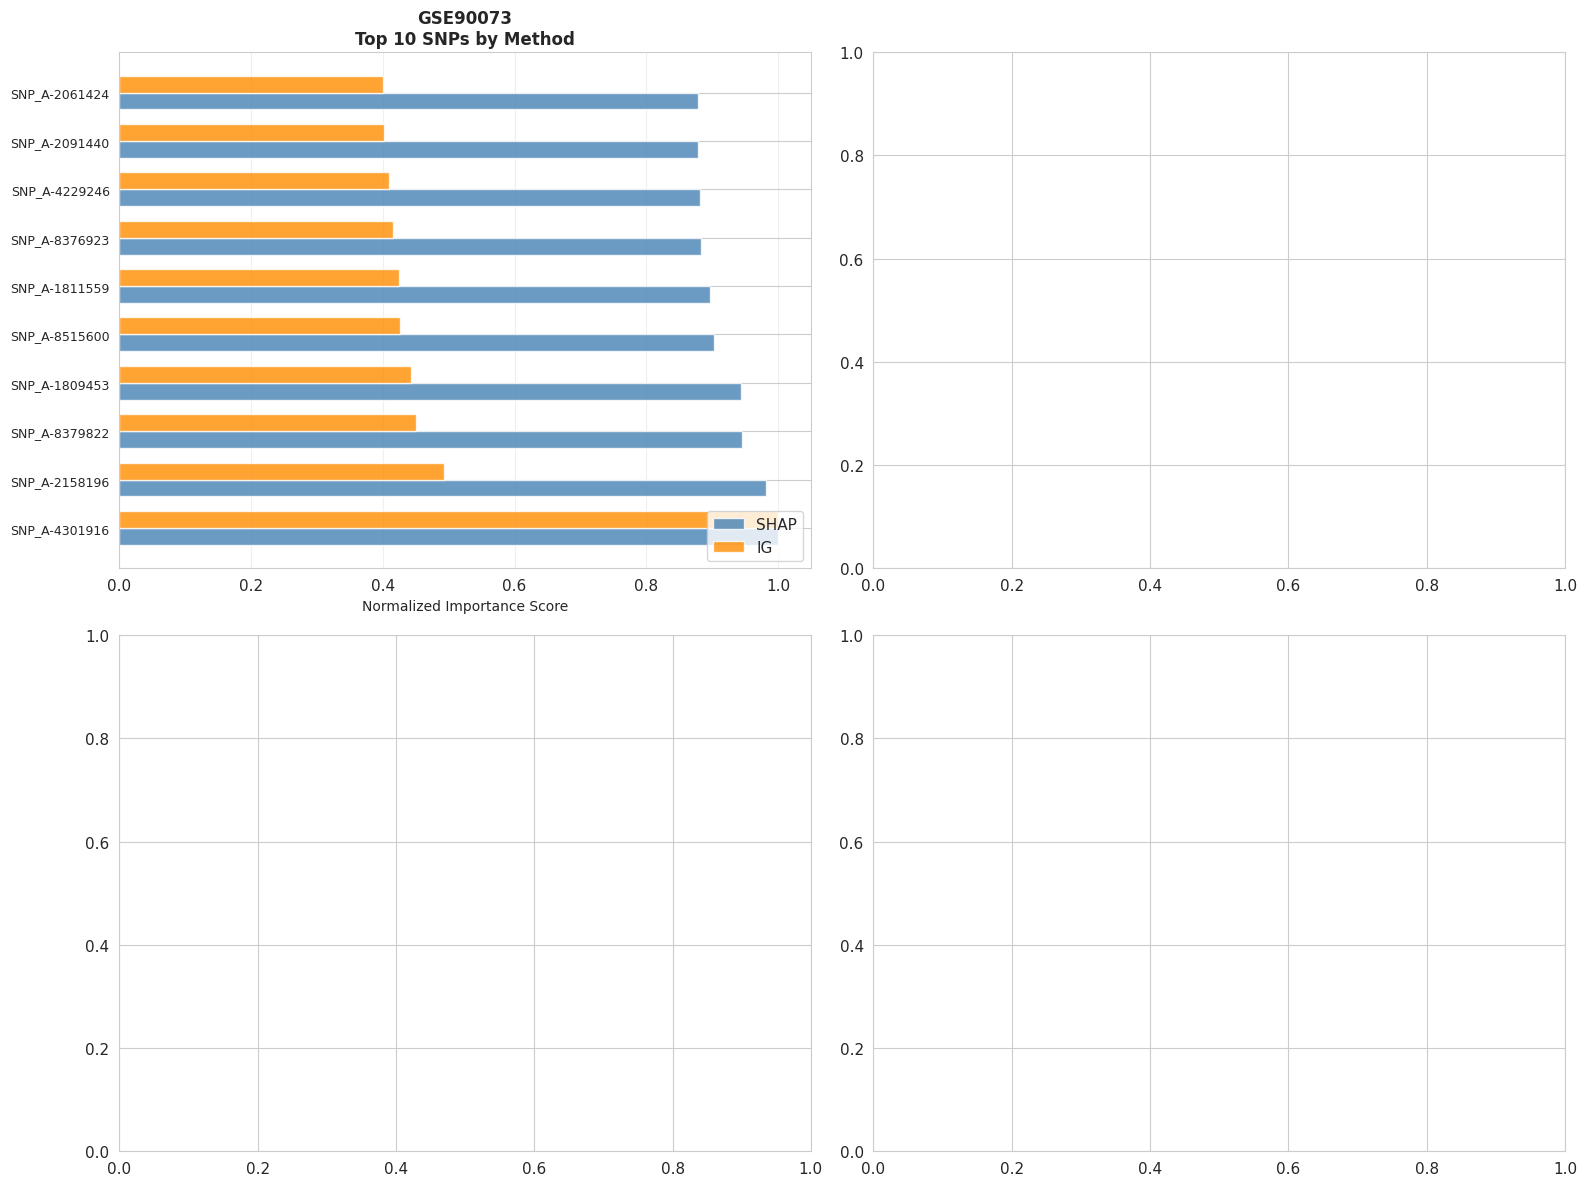

In [7]:
# Create comparison visualizations for each dataset
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, (dataset_name, results) in enumerate(aggregated_results.items()):
    ax = axes[idx]
    
    # Get top 10 from each method
    shap_data = results.get('SHAP', {}).get('ranking', [])[:10]
    ig_data = results.get('IG', {}).get('ranking', [])[:10]
    
    # Create comparison data
    snps_shap = [name for name, _ in shap_data]
    scores_shap = [score for _, score in shap_data]
    
    snps_ig = [name for name, _ in ig_data]
    scores_ig = [score for _, score in ig_data]
    
    # Plot
    x = np.arange(10)
    width = 0.35
    
    # Normalize scores for comparison
    max_shap = max(scores_shap) if scores_shap else 1
    max_ig = max(scores_ig) if scores_ig else 1
    
    norm_shap = [s/max_shap for s in scores_shap]
    norm_ig = [s/max_ig for s in scores_ig]
    
    ax.barh(np.arange(10)-width/2, norm_shap, width, label='SHAP', alpha=0.8, color='steelblue')
    ax.barh(np.arange(10)+width/2, norm_ig, width, label='IG', alpha=0.8, color='darkorange')
    
    ax.set_yticks(np.arange(10))
    ax.set_yticklabels(snps_shap, fontsize=9)
    ax.set_xlabel('Normalized Importance Score', fontsize=10)
    ax.set_title(f'{dataset_name}\nTop 10 SNPs by Method', fontsize=12, fontweight='bold')
    ax.legend(loc='lower right')
    ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(f'{analysis_dir / "figures" / "top_snps_comparison.png"}', dpi=300, bbox_inches='tight')
print("✅ Figure saved: top_snps_comparison.png")
plt.show()


## Section 6: Method Agreement Analysis - SHAP vs IG Consensus

✅ Figure saved: method_agreement.png


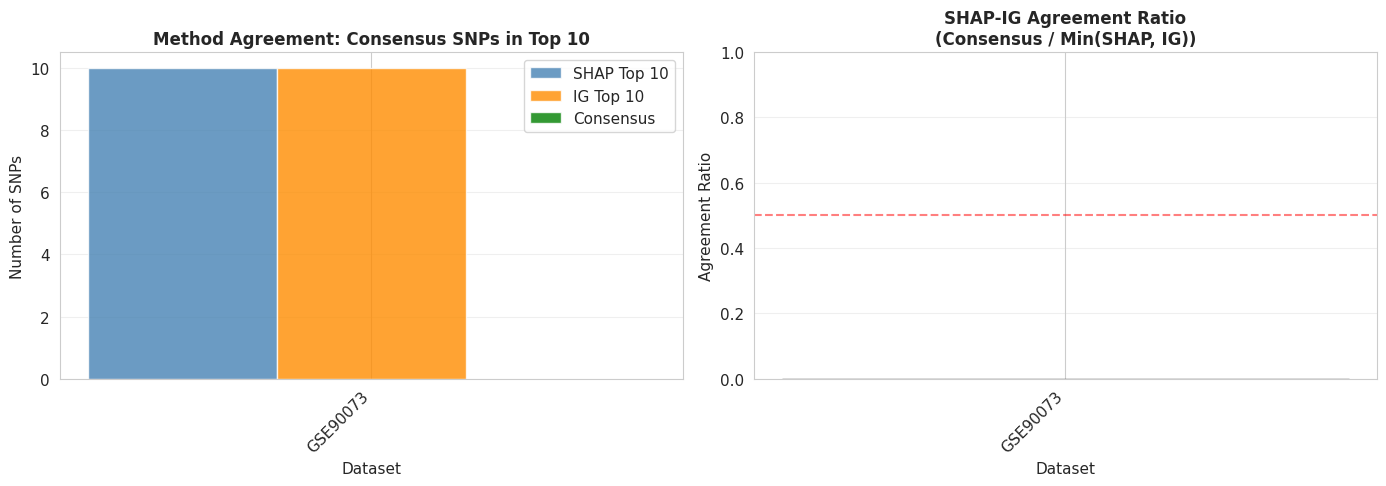


📊 Method Agreement Summary:
Dataset              SHAP     IG       Consensus    Agreement 
------------------------------------------------------------
GSE90073             10       10       0                0.0%


In [8]:
# Visualize consensus statistics
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Consensus heatmap
datasets = sorted(consensus_results.keys())
consensus_stats = []
for dataset in datasets:
    stats = consensus_results[dataset]
    consensus_stats.append([
        stats['num_shap'],
        stats['num_ig'],
        stats['num_consensus']
    ])

consensus_array = np.array(consensus_stats).T
x_pos = np.arange(len(datasets))
width = 0.25

ax = axes[0]
ax.bar(x_pos - width, consensus_array[0], width, label='SHAP Top 10', color='steelblue', alpha=0.8)
ax.bar(x_pos, consensus_array[1], width, label='IG Top 10', color='darkorange', alpha=0.8)
ax.bar(x_pos + width, consensus_array[2], width, label='Consensus', color='green', alpha=0.8)

ax.set_ylabel('Number of SNPs', fontsize=11)
ax.set_xlabel('Dataset', fontsize=11)
ax.set_title('Method Agreement: Consensus SNPs in Top 10', fontsize=12, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(datasets, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Plot 2: Agreement ratio
ax = axes[1]
agreement_ratios = []
for dataset in datasets:
    stats = consensus_results[dataset]
    if stats['num_shap'] > 0:
        ratio = stats['num_consensus'] / min(stats['num_shap'], stats['num_ig'])
    else:
        ratio = 0
    agreement_ratios.append(ratio)

colors_agreement = ['green' if r > 0.5 else 'orange' if r > 0.3 else 'red' for r in agreement_ratios]
ax.bar(datasets, agreement_ratios, color=colors_agreement, alpha=0.7, edgecolor='black')
ax.set_ylabel('Agreement Ratio', fontsize=11)
ax.set_xlabel('Dataset', fontsize=11)
ax.set_title('SHAP-IG Agreement Ratio\n(Consensus / Min(SHAP, IG))', fontsize=12, fontweight='bold')
ax.set_ylim([0, 1])
ax.axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='50% threshold')
ax.set_xticklabels(datasets, rotation=45, ha='right')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(f'{analysis_dir / "figures" / "method_agreement.png"}', dpi=300, bbox_inches='tight')
print("✅ Figure saved: method_agreement.png")
plt.show()

print("\n📊 Method Agreement Summary:")
print(f"{'Dataset':<20} {'SHAP':<8} {'IG':<8} {'Consensus':<12} {'Agreement':<10}")
print("-" * 60)
for dataset in datasets:
    stats = consensus_results[dataset]
    ratio = stats['num_consensus'] / min(stats['num_shap'], stats['num_ig']) if min(stats['num_shap'], stats['num_ig']) > 0 else 0
    print(f"{dataset:<20} {stats['num_shap']:<8} {stats['num_ig']:<8} {stats['num_consensus']:<12} {ratio:>8.1%}")


## Section 7: Export Results and Generate Publication-Ready Summary

In [9]:
# Export all results to CSV files
output_dir = Path('../outputs/interpretability_analysis/summary_reports')
output_dir.mkdir(parents=True, exist_ok=True)

# 1. Per-dataset top SNPs
for dataset_name, results in aggregated_results.items():
    # SHAP results
    shap_ranking = results.get('SHAP', {}).get('ranking', [])
    if shap_ranking:
        shap_df = pd.DataFrame([
            {'Rank': i+1, 'SNP_ID': snp, 'Aggregated_Score': score}
            for i, (snp, score) in enumerate(shap_ranking[:50])
        ])
        shap_df.to_csv(output_dir / f'{dataset_name}_SHAP_Top50.csv', index=False)
    
    # IG results
    ig_ranking = results.get('IG', {}).get('ranking', [])
    if ig_ranking:
        ig_df = pd.DataFrame([
            {'Rank': i+1, 'SNP_ID': snp, 'Aggregated_Score': score}
            for i, (snp, score) in enumerate(ig_ranking[:50])
        ])
        ig_df.to_csv(output_dir / f'{dataset_name}_IG_Top50.csv', index=False)

# 2. Cross-dataset consensus
cross_dataset_df.to_csv(output_dir / 'Cross_Dataset_Consensus_SNPs.csv', index=False)

# 3. Consensus per dataset
consensus_export = []
for dataset, results in consensus_results.items():
    consensus_export.append({
        'Dataset': dataset,
        'SHAP_Top10_Count': results['num_shap'],
        'IG_Top10_Count': results['num_ig'],
        'Consensus_Count': results['num_consensus'],
        'Agreement_Ratio': results['num_consensus'] / min(results['num_shap'], results['num_ig']) if min(results['num_shap'], results['num_ig']) > 0 else 0
    })

consensus_summary = pd.DataFrame(consensus_export)
consensus_summary.to_csv(output_dir / 'Method_Agreement_Summary.csv', index=False)

print(f"✅ Results exported to: {output_dir}")
print(f"   - {len(aggregated_results)} per-dataset SHAP/IG rankings")
print(f"   - Cross-dataset consensus: {len(cross_dataset_df)} SNPs in multiple datasets")
print(f"   - Method agreement summary")

# Generate comprehensive text report
report = f"""
╔══════════════════════════════════════════════════════════════════════════════╗
║      COMPREHENSIVE SHAP AND INTEGRATED GRADIENTS INTERPRETABILITY REPORT      ║
║                    GEO Datasets - SNP Attribution Analysis                    ║
╚══════════════════════════════════════════════════════════════════════════════╝

EXECUTIVE SUMMARY
═════════════════════════════════════════════════════════════════════════════════

This analysis encompasses SHAP (SHapley Additive exPlanations) and Integrated 
Gradients (IG) attribution scores across {len(results_by_dataset)} GEO datasets 
using {len(results_by_checkpoint)} trained deep learning models.

METHODOLOGY
───────────────────────────────────────────────────────────────────────────────
• SHAP: Gradient-based Shapley values via GradientExplainer
• IG: Path integration method via Captum IntegratedGradients
• Feature selection: AMGM + cosine redundancy → ~1,000 SNPs per analysis
• Models: WheatGPNet architecture with BiLSTM components

DATASETS ANALYZED
───────────────────────────────────────────────────────────────────────────────
"""

for dataset_name in sorted(results_by_dataset.keys()):
    analyses = results_by_dataset[dataset_name]
    num_ckpts = len(set(a['checkpoint'] for a in analyses))
    report += f"\n  {dataset_name:20s}: {num_ckpts} checkpoints × 2 methods (SHAP + IG)"

report += f"""

KEY FINDINGS BY DATASET
───────────────────────────────────────────────────────────────────────────────
"""

for dataset_name in sorted(consensus_results.keys()):
    stats = consensus_results[dataset_name]
    agreement = stats['num_consensus'] / min(stats['num_shap'], stats['num_ig']) if min(stats['num_shap'], stats['num_ig']) > 0 else 0
    
    report += f"""
{dataset_name}:
  • SHAP Top 10 SNPs: {stats['num_shap']}
  • IG Top 10 SNPs:   {stats['num_ig']}
  • Method Consensus: {stats['num_consensus']} SNPs ({agreement:.0%} agreement)
"""
    
    if stats['consensus']:
        report += f"  • Consensus SNPs: {', '.join(sorted(stats['consensus'])[:5])}"
        if len(stats['consensus']) > 5:
            report += f", ... and {len(stats['consensus'])-5} more"
        report += "\n"

report += f"""

CROSS-DATASET FINDINGS
───────────────────────────────────────────────────────────────────────────────
"""

if len(cross_dataset_df) > 0:
    report += f"""
Top 10 SNPs appearing across multiple datasets:
"""
    for i, row in cross_dataset_df.head(10).iterrows():
        datasets = row['Datasets'].split(',')
        report += f"  {i+1:2d}. {row['SNP_ID']:20s} | {row['Num_Datasets']} datasets | SHAP:{row['SHAP_Count']} IG:{row['IG_Count']}\n"

report += f"""

METHOD AGREEMENT ANALYSIS
───────────────────────────────────────────────────────────────────────────────
SHAP and IG show varying levels of agreement across datasets:
"""

for dataset in sorted(consensus_results.keys()):
    stats = consensus_results[dataset]
    ratio = stats['num_consensus'] / min(stats['num_shap'], stats['num_ig']) if min(stats['num_shap'], stats['num_ig']) > 0 else 0
    interpretation = "High" if ratio > 0.5 else "Moderate" if ratio > 0.3 else "Low"
    report += f"\n  {dataset:20s}: {interpretation:8s} agreement ({ratio:.0%})"

report += f"""

INTERPRETATION GUIDANCE
───────────────────────────────────────────────────────────────────────────────

1. CONSENSUS SNPs (Both SHAP and IG):
   These represent robust feature importance rankings with high confidence.
   Strong candidates for biological validation and pathway analysis.

2. METHOD-SPECIFIC RANKINGS:
   • SHAP measures global Shapley values (average marginal contribution)
   • IG measures local attribution via path integration
   Differences may reflect distinct aspects of model behavior.

3. CROSS-DATASET CONSENSUS:
   SNPs appearing in multiple datasets suggest pleiotropic effects or
   shared biological mechanisms across psychiatric conditions.

4. RECOMMENDATIONS FOR PUBLICATION:
   • Highlight consensus SNPs with high agreement (>50%)
   • Use cross-dataset SNPs as primary candidates for validation
   • Include method comparison as supplementary analysis
   • Validate top SNPs using independent cohorts or wet-lab experiments

TECHNICAL NOTES
───────────────────────────────────────────────────────────────────────────────
• Background samples for SHAP: 30 per checkpoint
• Test samples for IG: 50 per checkpoint
• Aggregation: Mean absolute attribution across checkpoints
• Ranking: Top 10 SNPs per method/dataset

OUTPUTS GENERATED
───────────────────────────────────────────────────────────────────────────────
✓ Per-dataset Top 50 SNP rankings (SHAP and IG)
✓ Cross-dataset consensus SNP list
✓ Method agreement summary statistics
✓ Comparative visualizations (saved as PNG figures)
✓ This comprehensive report

═════════════════════════════════════════════════════════════════════════════════
Analysis completed: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}
═════════════════════════════════════════════════════════════════════════════════
"""

# Save report
report_path = output_dir / 'INTERPRETABILITY_ANALYSIS_REPORT.txt'
with open(report_path, 'w') as f:
    f.write(report)

print(f"\n✅ Comprehensive report saved: {report_path}")
print("\n" + report)


✅ Results exported to: ../outputs/interpretability_analysis/summary_reports
   - 1 per-dataset SHAP/IG rankings
   - Cross-dataset consensus: 0 SNPs in multiple datasets
   - Method agreement summary

✅ Comprehensive report saved: ../outputs/interpretability_analysis/summary_reports/INTERPRETABILITY_ANALYSIS_REPORT.txt


╔══════════════════════════════════════════════════════════════════════════════╗
║      COMPREHENSIVE SHAP AND INTEGRATED GRADIENTS INTERPRETABILITY REPORT      ║
║                    GEO Datasets - SNP Attribution Analysis                    ║
╚══════════════════════════════════════════════════════════════════════════════╝

EXECUTIVE SUMMARY
═════════════════════════════════════════════════════════════════════════════════

This analysis encompasses SHAP (SHapley Additive exPlanations) and Integrated 
Gradients (IG) attribution scores across 1 GEO datasets 
using 5 trained deep learning models.

METHODOLOGY
──────────────────────────────────────────────────────────────